# What exactly is PyTorch doing?

Open Source deep learning software framework developed by Facebook's AI research group.

Based on the previously popular Torch framework that 

PyTorch: Written in Python, C, C++, CUDA.

## Structure of Talk:

 - Mathematics of Deep Learning / Backpropagation
 
 - Automatic Differentation, how and why?
 
 - How autodiff is implemented in PyTorch (vs others)

![c](https://i.postimg.cc/4xjVQ04r/pytorch.gif)

## BackPropogation:

    
Neural Networks are trained using **backpropagation**
 
Backpropogation is essentially the chain rule of differentation in action.

<div class="alert alert-block alert-info">
If $z = f(y)$ and $y = g(x)$:
$$
\frac{dz}{dx}= \frac{dz}{dy} \cdot \frac{dy}{dx}
$$
</div>

### How does BackPropogation work?

Backpropogation is simply the application of the chain rule, and partial differentation, to function approximators that we call *Neural Networks*
#### Worked Example

Here is a reference image for a simple Neural Network layer.
<br/><br/>
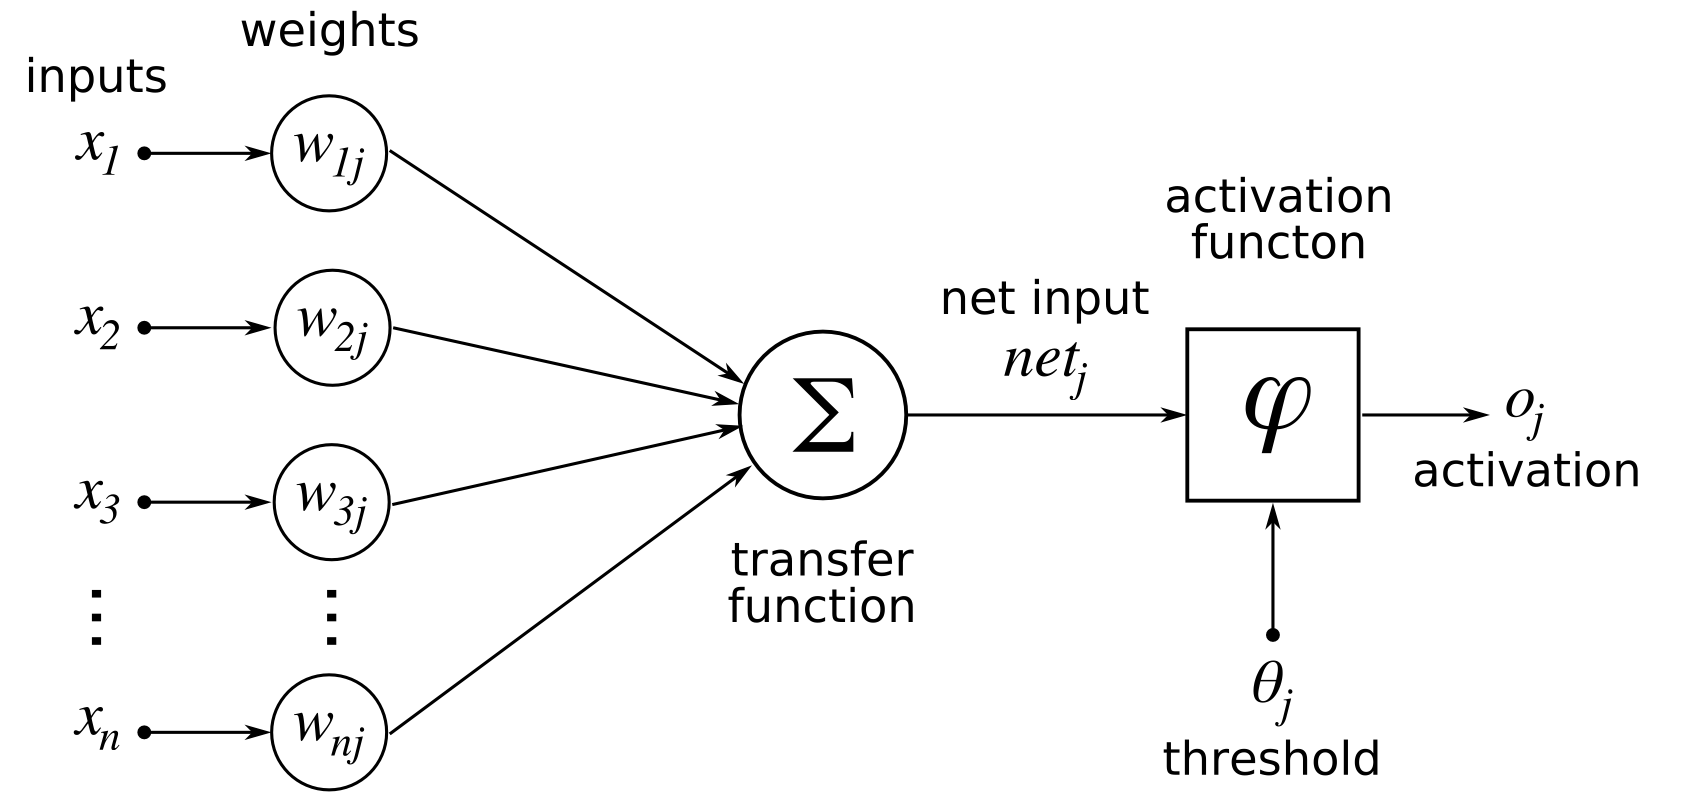

Remember that this shows just one arbitrary layer, $j$.
<br/><br/>
There are the weights $w_{ij}$, the network input $net_j$ (which can be the weighted sum of $o_k$ previous neurons), and the output $o_j$.  
Our aim is to minimise some error, $E$, which in this case we take to be a supervised task and thus given by 
$E = L(y_{true}, y)$

We are looking for the change in the Error with respect to changes in individual weights alone, $$\frac{\partial E}{\partial w_{ij}}$$ So we use the chain rule twice:
$$
\frac{\partial E}{\partial w_{ij}} = \frac{\partial E}{\partial o_j} \frac{\partial o_j}{\partial w_{ij}}
= \frac{\partial E}{\partial o_j}\frac{\partial o_j}{\partial \text{net}_j}\frac{\partial \text{net}_j}{\partial w_{ij}}$$

<div class="alert alert-block alert-info">
    <b> Weight Formula: </b>$$
\frac{\partial E}{\partial w_{ij}} = \frac{\partial E}{\partial o_j}\frac{\partial o_j}{\partial \text{net}_j}\frac{\partial \text{net}_j}{\partial w_{ij}}$$
</div>

### Breaking down these terms

#### The net-weight term

The third term in the above is the easiest to understand.
$$\frac{\partial \text{net}_j}{\partial w_{ij}}$$
Since net$_j$ is in fact defined as the sum of the previous outputs $o_k$ weighted by $w_{ij}$ so the only non vanishing term is the $w_{ij}$ term. Formally: <br></br>

$$\frac{\partial \text{net}_j}{\partial w_{ij}} = \frac{\partial \text{ }}{\partial w_{ij}} \big(\sum_{k=1}^{n} w_{kj} o_k \big) = o_i $$

In plain terms, how does the network input (which is a weighted sum of previous outputs) change with one of the weights? It changes by an amount equal to the output being weighted. (If the layer $j$ is the input layer then instead of a previous output its an input.)

#### The Activation Function Term
Also easy to understand is $$\frac{\partial o_j}{\partial \text{net}_j}$$ 
since $o_j$ is directly related to $\text{net}_j$ through the activation function $\psi$
$$ \frac{\partial o_j}{\partial \text{net}_j} = \frac{\partial \psi(\text{net}_j)}{\partial \text{net}_j}$$

This is simply the derivative of the activation function. This is why it is often stated that the activation function should be a differentiable function. In fact, often the activation functions used have rather convenient forms for their derivates. An example is the logistics function <br></br>

$$ \psi(z) = \frac{1}{1+e^{-z}}$$
who's derivative is a lovely
$$\psi'(z) = \psi(z)(1-\psi(z))$$


It's interesting to note that theres actually some flexibility here. Mathematically ReLU() is not a differentiable function but in practical terms its derivative can actually be very easily defined. 
ReLU is defined as $\psi(z) = max(0,z)$ which has derivative 0 or 1 for negative, positive $z$ respectively. It is not defined for the case where $z=0$ so it is common to set it to some value, usually either $0, 0.5$ or $1$  PyTorch (**I THINK**) sets it to 0.

An alternative approach is to approximate it with the differentiable function $f(x) = log(1+e^x)$ whos derivative is just the logistics function.

#### The Error Term
$$
\frac{\partial E}{\partial o_j}
$$
The first term is the difficult one. It is sometimes referred to as the *error* but I will avoid this due to potential confusion.

##### If j is the output layer

In the case that its the output layer, then it becomes fairly simple and depends on the construction of the problem and the exist error function. If we imagine a supervised learning problen, the output $o_j = y$ and we need to differentiate the loss function.
With the L1 loss: <br></br>
$$\frac{\partial E}{\partial o_j}= \frac{\partial |y_{true} - y|}{\partial y} = \pm 1$$
depending on whether or not $y$ is larger than $y_{true}$. 
The gradient is the same even for both very small and very large errors. This makes it harder to converge, but also more resistant to outliers. 

With the L2 loss the gradient is analytic: 
$$\frac{\partial E}{\partial o_j}= \frac{\partial  \frac{1}{2} (y_{true} - y)^2}{\partial y} = (y_{true} - y)$$
It can blow up for outliers, but will scale as the error increases, yielding much better convergence.

##### If j is not an output layer
$$\frac{\partial E}{\partial o_j}$$

One cannot arbitrarily calculate this, but **can** use the errors of subsequent layers (closer to the output). This is where backpropagation gets its name.

The precise reason that it is difficult to evaluate the above term is because $E$ is dependent on $o_j$ in a non-trivial way depending on how the neural network propagates the value of $o_j$. We can resolve this using *total derivates*. 

<div class="alert alert-block alert-info">
    <b> Total Derivative of Multivariable Function: </b>
    
For function $f\big{(}g(x), y(x), z(x)\big{)}$ one can take total derivates to find $\large\frac{df}{dx}$:

$$\frac{df}{dx} = \frac{\partial f}{\partial g} \frac{\partial g}{\partial x} + \frac{\partial f}{\partial y} \frac{\partial y}{\partial x}+\frac{\partial f}{\partial z} \frac{\partial z}{\partial x}$$
</div>

We can think of the Error as an implicit function of $o_j$. Let the loss be a function of every single neuron that receives an input from $o_j$, i.e $L(u,v,w,x,y,z)$.

We can therefore define $\large\frac{\partial E}{\partial o_j}$ recursively by calculating the gradients of the neurons in the following layer.
$$
\frac{\partial E}{\partial o_j}= \sum_{k=1}^K \big{(} \frac{\partial E}{\partial o_k}\frac{\partial o_k}{\partial o_j} \big{)}
$$where we define $K$ neurons in layer $k$ (i.e the layer after $j$).

#### Lemma: Convolutional Layers:

Convolutional layers have a nice interesting way of backpropagating their errors.

By convolution.

<img src="https://miro.medium.com/max/700/1*5QPqJEmBqotN4Dab2TWqFQ.jpeg" width="500">


Using partial derivatives, one can find the gradient as:

$$ \frac{\partial E}{\partial F_{11}} = \frac{\partial E}{\partial O_{11}} \frac{\partial O_{11}}{\partial F_{11}} +\frac{\partial E}{\partial O_{12}} \frac{\partial O_{12}}{\partial F_{11}} +\frac{\partial E}{\partial O_{21}} \frac{\partial O_{21}}{\partial F_{11}} + \frac{\partial E}{\partial O_{22}} \frac{\partial O_{22}}{\partial F_{11}} \text{, etc}$$ 
$\frac{\partial O_{11}}{\partial F_{11}} = X_{11} \ldots$ so error is in fact:

<img src="https://miro.medium.com/max/700/1*auj7ULC2kRCa99_6u1QSNA.jpeg" width="550">


### Forward and Backward Passes

Backpropagation is the backwards *propogation* of the $\large\frac{\partial E}{\partial o_j}$ error term for each layer. This is the **backward pass**. However, the actual values needed to calculate the gradients can only be calculated during a **forward pass** of the neural network. 

So a standard backpropogation will begin with a forward pass that utilises the inputs, weights and activation functions, and the backward pass will use all the outputs and activations to calculate the errors. 

**Note that all of the outputs are needed from the forward phase before the backward phase can begin.**

# Differentiable Programming with Automatic Differentiation:

Differentiable programming is a programming paradigm which allows for rapid and efficient calculation of gradients of arbitrary functions and has played an enormous, albeit rather unseen, part in the growth and development of machine learning and, earlier, numerical optimization. 

The main method used - which is what will be discussed here - is **automatic differentiation**.

**What is the derivative of $f(x) = \mathbf{\text{cos}(x)}$?**<br></br>
$f'(x) = - \text{sin}(x)$

What about the derivative of an arbitrary function $f(x)$ at some point $x=a$?<br></br>
HARDER THAN YOU THINK!


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/AutomaticDifferentiationNutshell.png/1920px-AutomaticDifferentiationNutshell.png" width="550">

**Option 1: Symbolic Differentiation**

Inefficient code, difficult to convert entire program into single symbolic expression. Eg: *Mathematica*

**Option 2: Numerical Differentation**

Rounding errors creep in from discretization. 


For example, consider the method of *divided differences*, for the *simple* function $f(x) = x^3$

$$\text{error in estimate} = \frac{f(x+h) - f(x)}{h} - 3x^2, \text{for arbitrarily small h}$$
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/AbsoluteErrorNumericalDifferentiationExample.png/300px-AbsoluteErrorNumericalDifferentiationExample.png" width="550">

The graph above shows that choice of h is difficult even for a very simple function. 

Both find it difficult to calculate higher derivatives. Both are **VERY BAD** at calculating partial derivates of functions of *many, many* arguments.

**Solution: Automatic Differentiation**

Automatic differentation allows for a systematic way to find the gradient of a function.
The best way to understand automatic differentation is through a worked example. <br></br>
Consider the function $$f(x_1, x_2) = x_1 x_2 + \text{sin} x_1$$

How does one evaluate this function? Use *sub expressions*, $w$

$$\begin{align}
z &= f(x_1,x_2) \\ &= x_1 x_2 + \text{sin} (x_1) \\&= w_1 w_2 + \text{sin} (w_1),  \quad\leftarrow w_1 = x_1, w_2 = x_2 \\&= w_3 + w_4, \quad \leftarrow w_3 = w_1 w_2, w_4 = \text{sin} (w_1) \\ &= w_5 \quad \leftarrow w_5 = w_3 + w_4\end{align}$$

we can use this to create a *dual program* to find the derivate with respect to $x_2$.

$$\begin{align}
&w_1 = x_1 \quad \quad \quad \quad \dot{w_1} = 0 \ (seed)\\
&w_2 = x_2 \quad \quad \quad \quad \dot{w_2} = 1 \ (seed)\\
&w_3 = w_1 \cdot w_2 \quad \quad \dot{w_3} = \dot{w_1}w_2 +\dot{w_2} w_1 = 0 \cdot x_2 + 1 \cdot x_1\\
&w_4 = \text{sin}(w_1) \quad \quad \dot{w_4} = \text{cos}(w_1) \dot{w_1} = 0 \cdot \text{cos}(x_1)\\
&w_5 = w_3 + w_4 \quad \quad \dot{w_5} = \dot{w_3}w_4 +\dot{w_4} w_3 = x_1+0 = x_1
\end{align}$$
reveals that $\large{\frac{\partial f}{\partial x_2}} = x_1$



This is well represented using computational graphs. The same computational graph that calculates a function can be adapted to also calculate its derivative.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/ForwardAccumulationAutomaticDifferentiation.png/450px-ForwardAccumulationAutomaticDifferentiation.png" width="550">
There are of course, reverse computational graphs too, for the backward pass. The reverse path calculates $\large\frac{\partial f}{\partial w_i}$$\equiv \bar{w_i}$ 
$$\begin{align}
&w_1 = x_1 \\
&w_2 = x_2 \\
&w_3 = w_1 \\
&w_4 = \text{sin}(w_1) \\
&w_5 = w_3 + w_4 
\end{align}$$


$$\begin{align}
&\bar{w_5} = 1 (seed)\\
&\bar{w_4} = \bar{w_5} \quad \text{since } \bar{w_4} = \bar{w_5} \cdot \frac{\partial w_5}{\partial w_4}\\
&\bar{w_3} = \bar{w_5}\\
&\bar{w_2} = \bar{w_3} \cdot w_1\\
&\bar{w_1} = \bar{w_3} \cdot w_2 + \bar{w_4}\cdot \text{cos}(w_1)
\end{align}
$$




<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/ReverseaccumulationAD.png/450px-ReverseaccumulationAD.png" width="550">


Backwards and forwards computation of gradients are roughly equivalent, but backwards is more memory intensive as it requires access to the intermediate variables $w_i$. 


**Constructing and storing computational graphs is the main role of deep learning frameworks. It defines what functions they can find gradients for, and how. In PyTorch, this is done in C++ for efficiency.**

# Static vs Dynamic Graphs

## Static

At this point, I have explained the method from a static approach. We took the entire function and then derived an expression for its derivative. This method is known as *source code transformation* and takes place at compiler level. It is actually surprisingly efficient, but at the same time very inflexible. It was a huge issue for TensorFlow that they couldnt build graphs dynamically and therefore handle different length sentences in NLP applications because of it but they did eventually find a workaround to make their graphs dynamic.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/SourceTransformationAutomaticDifferentiation.png/1920px-SourceTransformationAutomaticDifferentiation.png" width="550">

## Dynamic

The alternative is to have dynamic graphs. What this means is that the graph is computed at run-time, giving much greater flexibility. It does this by combining *gradient-enabled tensors* as *variables* alongside functions as operators.
Instead the user defines the graph when they define variables. So when you define a variable in PyTorch, there is an unseen boolean *requires_grad* attached (default True). If True, PyTorch will track the operation history and the autograd class will include this variable in the backwards graph and calculate its gradients. 

### Differentiating with Dual Numbers

How does autograd do derivatives so dynamically? It uses Dual Numbers.

Dual numbers extend the field of real numbers similar to complex numbers.

**Complex Numbers**:  $z \rightarrow a + bi, \quad i^2 = -1$

**Dual Numbers**:  $z \rightarrow a + b\epsilon \quad \epsilon^2 = 0$

Dual numbers gives you the derivatives of functions by evaluating them.

Given any polynomial $$P(x) = p_0 + p_1 x + p_2 x^2 \ldots$$
We can calculate the derivative by extending $x$ to include dual numbers.

$$\begin{align}P(a+b\epsilon) &= p_0 + p_1 (a+b\epsilon) + p_2 (a+b\epsilon)^2 + \ldots...+ p_n(a+b\epsilon)^n\\
= p_0 + &p_1 a + p_2 a^2 +\ldots +p_n a^n \\
&= p_1 b\epsilon + 2p_2 ba\epsilon + \ldots + n p_n a^{n-1} b \epsilon\\
&= P(a) + b\epsilon P'(a)
\end{align}$$

$P'(a)$ can be read off in the dual component of the result. By using Taylor series expansions, we can apply this to any real valued function (and indeed this is the usual way that functions like sin and log are computed).

This changed arithmetic requires flexibility in mathematical operations and objects defined for real numbers. This is achieved using *operator overloading*. Operator overleading is where the definition of operations and even data types can be adapted. Not all programming languages support this. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/OperatorOverloadingAutomaticDifferentiation.png/450px-OperatorOverloadingAutomaticDifferentiation.png" width="550">


![c](https://i.postimg.cc/4xjVQ04r/pytorch.gif)

# Conclusion

There is a looooot more to talk about, but I haven't had the time. 

 - Its important to remember the maths behind it all, even if its mostly just the chain rule
 - Remember that you defining the computational graph, this gives you flexibility. 
 - This is a changing field. Julia, for example, takes the syntax itself as the graph. One day, symbolic differentiation may render automatic differentiation mute.
 
 

 